In [1]:
### Setup the RADAR parameters

In [2]:
Pavg = 100e3        # Basic Power level output of the radar
Gt = 15             # Scalar Gain of TX antenna
Gr = Gt             # Scalar Gain of RX antenna  if Gr == Gt same antenna
fc = 5e3            # Carrier Frequency, Center Frequency
#vp = 3e8            # Phase Velocity of the EM wave
vp = 343            # Phase Velocity of sound
NF = 1              # Receiver Noise Figure
T  = 1/fc           # period of one Carrier Frequency
#derived values
Lambda = vp/fc

print(T)

# Setup Time portion
PRF = 0.5           # Pulses per second (hertz)
PRI = 1/PRF         # Pulse Repetition Interval (seconds)
R_unamb = PRI *vp/2 # Unambiguous Range
print(R_unamb)

#Num cycles per pulse packet
k = 100             # k cycles of fc in the pulse packet
PW = k*T            # k cycles * Period of fc
BW = 1/PW           # Bandwidth of the RADAR Pulse
print(PW)

# error check
if PW >= PRI:
    print('Error: Pulse width much too long -- PRI: {}, PW = {}'.format(PRI, PW))


0.0002
343.0
0.02


In [15]:
import pyaudio
import wave
import sys
import matplotlib.pyplot as plt
import numpy as np
from time import sleep

import librosa
import librosa.display

import pylab

# recording configs
CHUNK = 2048
FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 96000
RECORD_SECONDS = 10
WAVE_OUTPUT_FILENAME = "output.wav"

# create & configure microphone
mic = pyaudio.PyAudio()
stream = mic.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)



# read & store microphone data per frame read
frames = []
trigger = 0
sleep(0.01)
while trigger < 20000:
    dataTrig = stream.read(CHUNK)
    decoded = np.frombuffer(dataTrig,dtype=np.int16);
    trigger = np.amax(decoded)
    display(trigger)
    sleep(0.001)

print("* recording")

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    numpydata = np.frombuffer(data,dtype=np.int16)
    frames.append(data)

print("* done recording")


# kill the mic and recording
stream.stop_stream()
stream.close()
mic.terminate()


28506

* recording
* done recording


In [16]:
#combine & store all microphone data to output.wav file
outputFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
outputFile.setnchannels(CHANNELS)
outputFile.setsampwidth(mic.get_sample_size(FORMAT))
outputFile.setframerate(RATE)
outputFile.writeframes(b''.join(frames))
outputFile.close()


# Plot
time = np.arange(0, float(numpydata.shape[0]), 1) / RATE
#plt.plot(time, numpydata)

# SciPy Import
import scipy.io.wavfile
rate,audData=scipy.io.wavfile.read('output.wav')

#the sample rate is the number of bits of infomration recorded per second
print(rate)
print(audData)

#wav bit type the amount of information recorded in each bit often 8, 16 or 32 bit
audData.dtype

#wav length
len_PRI = audData.shape[0] / rate

#wav number of channels mono/stereo 
audData.shape[1]

#if stereo grab both channels
channel1=audData #left 
# channel2=audData[:,1] #right

# FFT
# from numpy import fft as fft
# fourier=fft.fft(channel1)
# plt.plot(fourier, color='#ff7f00')
# plt.xlabel('k')
# plt.ylabel('Amplitude')



96000
[[2272 1077]
 [2066 1572]
 [1774 2017]
 ...
 [4557 3900]
 [4480 3445]
 [4393 3004]]


In [20]:
# N Observations Effect
# provide n observation effects
numPRI = RECORD_SECONDS+2
print(np.shape(channel1))

channel1_env = channel1.reshape(numPRI, int(len(channel1)/numPRI*CHANNELS))
# add them all together
n_obs_channel1_env = channel1_env.sum(axis=0)


print(np.shape(channel1_env))
print(len(n_obs_channel1_env))
lenPRI1 = int(len(n_obs_channel1_env)/numPRI)
print(lenPRI1)

(958464, 2)
(12, 159744)
159744
13312


343.0

31948

Text(0, 0.5, 'Power in Watts')

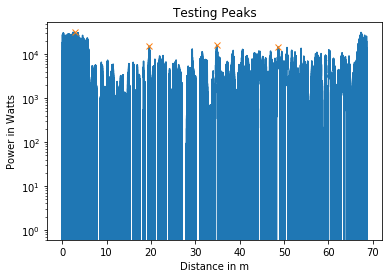

In [6]:
from scipy.signal import find_peaks

dBm = -100 #dBm
scalar = 1e-3 * np.power(10,(dBm/10))
#height = scalar

peaks, _ = find_peaks(n_obs_channel1_env, height=scalar, distance=5e3)
# peaks2 = np.clip(n_obs_main_trace_env, a_min=scalar, a_max=None)
peaks2 = peaks * R_unamb/(len(n_obs_channel1_env))

# make the distance vector
nsamps = int(len(n_obs_channel1_env)/5)
x = np.linspace(0,R_unamb/5, nsamps)
dx = R_unamb/nsamps/5
display(R_unamb)
display(nsamps)

peaks = peaks[0:int(len(peaks)/5)]

plt.semilogy(x,n_obs_channel1_env[0:nsamps])
plt.semilogy(peaks*dx,n_obs_channel1_env[peaks], 'x')
plt.title('Testing Peaks')
plt.xlabel('Distance in m')
plt.ylabel('Power in Watts')

In [7]:
# Peaks 2
#peaks3, _ = find_peaks(n_obs_channel1_env, height=scalar, distance=5e3)
#time3 = np.arange(0, len(n_obs_channel1_env), 1) / rate 
#display(peaks3)
#plt.plot(n_obs_channel1_env[peaks3], 'x')
#peaks = plt.semilogy(time2, n_obs_channel1_env[peaks3], linewidth=0.02, alpha=2.0, ls='x', color='#FF0000', label="Peaks")

159744
13312
13312
958464
958464


<Figure size 432x288 with 0 Axes>

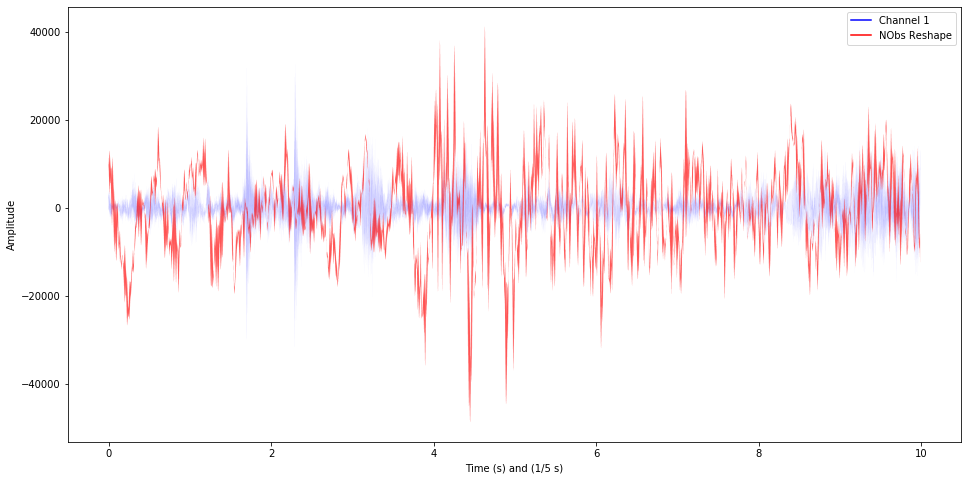

In [22]:
# PLOT
time = np.arange(0, float(audData.shape[0]), 1) / rate 
time2 = np.arange(0, float(audData.shape[0]/(6*numPRI)), 1) / rate*6*numPRI 

print(len(n_obs_channel1_env))
print(len(n_obs_channel1_env[0:lenPRI1]))
print(len(time2))
print(len(channel1))
print(len(time))

#plot amplitude (or loudness) over time
plt.clf()
plt.figure(figsize=(16,8))
channel1fig = plt.plot(time, channel1, linewidth=0.02, alpha=0.4, color='#0000FF', label="Channel 1")
NObsReshape = plt.plot(time2, n_obs_channel1_env[0:lenPRI1], linewidth=0.04, alpha=1.0, color='#FF0000', label="NObs Reshape")

plt.xlabel('Time (s) and (1/5 s)')
plt.ylabel('Amplitude')

# defining legend style and data
import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color='blue', label='Channel 1')
reds_line = mlines.Line2D([], [], color='red', label='NObs Reshape')

plt.legend(handles=[blue_line, reds_line],loc='upper right')